In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [28]:
import math
import os
import time


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product

from scipy.stats import pearsonr
from importlib import reload

from lib import sketches, visualization_utils, encoders, pacha_sketch, ploting
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)
reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover
from lib.pacha_sketch import PachaSketch, SpatialPachaSketch, HilbertPachaSketch, CMParameters, BFParameters, BaselineSketch

from lib.ploting import set_style, plot_ylabel, plot_legend

set_style()

In [3]:
df = pd.read_parquet("data/normal_3d_100k.parquet")

In [5]:
df.describe()

,d_0,d_1,d_2
count,100000.000000,100000.000000,100000.000000
mean,4999.381370,4999.287520,4999.427570
std,49.816793,50.016921,49.733705
min,4788.000000,4783.000000,4780.000000
25%,4966.000000,4966.000000,4966.000000
50%,5000.000000,4999.000000,4999.000000
75%,5033.000000,5033.000000,5033.000000
max,5241.000000,5219.000000,5217.000000


# Building Sketches

## Building Spatial Pacha-Sketches

In [15]:
cm_params = CMParameters(width=300000, depth=5)
bf_params = BFParameters(n_values=len(df), p=0.01)

In [16]:
spatial_pacha_sketch_5 = SpatialPachaSketch(num_dimensions=3, base=5, levels=4, cm_params=cm_params, bf_params=bf_params, sketch_type=["bf", "cm", "cm", "cm"])    

In [17]:
spatial_pacha_sketch_5.update_data_frame(df)

In [29]:
spatial_pacha_sketch_2 = SpatialPachaSketch(num_dimensions=3, base=2, levels=9, cm_params=cm_params, bf_params=bf_params, sketch_type=["bf"]+["cm"]*8)    
spatial_pacha_sketch_2.update_data_frame(df)

## Building Hilbert Pacha-Sketches

In [18]:
cm_params = CMParameters(width=300000, depth=5)
bf_params = BFParameters(n_values=len(df), p=0.01)

In [19]:
hilbert_pacha_sketch_5 = HilbertPachaSketch(num_dimensions=3, num_bits=13, base=5, levels=10, cm_params=cm_params, bf_params=bf_params, sketch_type=["bf"]*2+["cm"]*8)

In [20]:
hilbert_pacha_sketch_5.update_data_frame(df)

In [34]:
hilbert_pacha_sketch_5_v2 = HilbertPachaSketch(num_dimensions=3, num_bits=13, base=5, levels=10, cm_params=cm_params, bf_params=bf_params, sketch_type=["bf"]+["cm"]*9)
hilbert_pacha_sketch_5_v2.update_data_frame(df)

In [42]:
hilbert_pacha_sketch_2 = HilbertPachaSketch(num_dimensions=3, num_bits=13, base=2, levels=24, cm_params=cm_params, bf_params=bf_params, sketch_type=["bf"]+["cm"]*23)
hilbert_pacha_sketch_2.update_data_frame(df)

## Baseline Count-Min Sketch

In [29]:
cm_params = CMParameters(width=300000, depth=5)
cm_baseline = BaselineSketch(num_dimensions=3, cm_params=cm_params, sketch_type="cm")
cm_baseline.update_data_frame(df)

# Evaluation

## General Functions and Query Generation

In [4]:
levels = 4
base = 5
dimensions = 3

# Create queries
lower_bound = 4800
upper_bound = 5200 - base ** (levels-1)
n_samples = 20

queries_5 = []

for l in range(levels):
    l_queries = []
    for i in range(n_samples):
        start = np.random.randint(lower_bound, upper_bound)
        end = start + base**l - 1
        query = [(int(start), int(end))] * dimensions
        l_queries.append(query)
    queries_5.append(l_queries)

In [11]:
queries_df = pd.DataFrame(queries_5)
queries_df.to_parquet("queries/queries_5.parquet")

In [30]:
def evaluate_queries(pacha_sketch: PachaSketch, queries: list, flat_results: bool = True):
    true_results = []
    estimates = []
    absolute_errors = []
    relative_errors = []
    times = []

    for l in range(levels):
        l_true_results = []
        l_estimates = []
        l_absolute_errors = []
        l_relative_errors = []
        l_times = []

        for i in range(n_samples):
            query = queries[l][i]

            true_result = df.query(" and ".join([f"d_{i} >= {query[i][0]} and d_{i} <= {query[i][1]}" for i in range(dimensions)])).shape[0]
            
            start = time.time()
            estimate = pacha_sketch.query(query)
            end = time.time()
            l_times.append(end - start)

            l_true_results.append(true_result)
            l_estimates.append(int(estimate))

            l_absolute_errors.append(int(abs(true_result - estimate)))
            if true_result != 0:
                l_relative_errors.append(abs(true_result - estimate) / true_result)
            else:
                l_relative_errors.append(abs(true_result - estimate))
    
        print(f"level compleated: {l}")
        true_results.append(l_true_results)
        estimates.append(l_estimates)
        absolute_errors.append(l_absolute_errors)
        relative_errors.append(l_relative_errors)
        times.append(l_times)

    if flat_results:
        true_results = np.array(true_results).flatten()
        estimates = np.array(estimates).flatten()
        relative_errors = np.array(relative_errors).flatten()
        absolute_errors = np.array(absolute_errors).flatten()
        times = np.array(l_times).flatten()

    return true_results, estimates, absolute_errors, relative_errors, times
        

## Evaluating B-Adic Space Cover

In [19]:
true_results_s_5, estimates_s_5, absolute_errors_s_5, relative_errors_s_5 = evaluate_queries(pacha_sketch=spatial_pacha_sketch_5, queries=queries_5)


level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


In [30]:
true_results_s_2, estimates_s_2, absolute_errors_s_2, relative_errors_s_2 = evaluate_queries(pacha_sketch=spatial_pacha_sketch_2, queries=queries_5)

level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


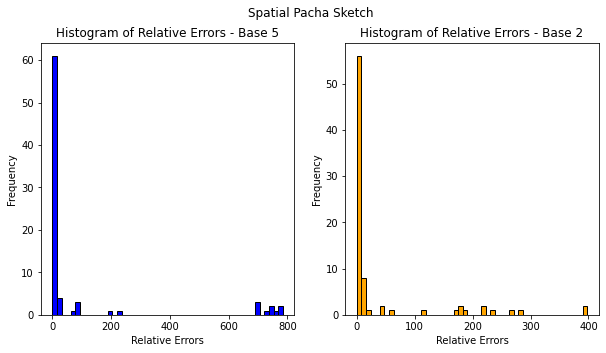

In [ ]:
plt.figure(figsize=(10, 5))
plt.suptitle('Spatial Pacha Sketch')

plt.subplot(1, 2, 1)
plt.hist(relative_errors_s_5, bins=50, edgecolor='black', color='blue')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors - Base 5')

plt.subplot(1, 2, 2)
plt.hist(relative_errors_s_2, bins=50, edgecolor='black', color='orange')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors - Base 2')

plt.show()

In [23]:
np.argmax(relative_errors)

np.int64(41)

In [25]:
i = np.argmax(relative_errors)

print(f"True result: {true_results[i]}")
print(f"Estimate: {estimates[i]}")
print(f"Relative error: {relative_errors[i]}")
print(f"Absolute error: {absolute_errors[i]}")

True result: 0
Estimate: 755
Relative error: 755.0
Absolute error: 755


In [26]:
results = np.asarray([true_results, estimates, relative_errors, absolute_errors]).T

In [27]:
sorted_results = results[results[:, 0].argsort()[::-1]]

In [28]:
query_sizes = []

for l in range(levels):
    query_sizes.append([l] * n_samples)

query_sizes = np.array(query_sizes).flatten()

In [30]:
data = {
    'Query Size': query_sizes,
    'True Results': true_results,
    'Estimates': estimates,
    'Relative Errors': relative_errors,
    'Absolute Errors': absolute_errors
}

df_results = pd.DataFrame(data)
df_results = df_results.sort_values(by='Relative Errors', ascending=True)
df_results.head()

,Query Size,True Results,Estimates,Relative Errors,Absolute Errors
0,0,0,0,0.0,0
1,0,0,0,0.0,0
2,0,0,0,0.0,0
3,0,0,0,0.0,0
4,0,0,0,0.0,0


In [32]:
print(df_results.to_string())


    Query Size  True Results  Estimates  Relative Errors  Absolute Errors
0            0             0          0         0.000000                0
1            0             0          0         0.000000                0
2            0             0          0         0.000000                0
3            0             0          0         0.000000                0
4            0             0          0         0.000000                0
5            0             1          1         0.000000                0
7            0             0          0         0.000000                0
8            0             0          0         0.000000                0
12           0             0          0         0.000000                0
9            0             0          0         0.000000                0
10           0             0          0         0.000000                0
11           0             0          0         0.000000                0
14           0             0          

In [31]:
sorted_results

array([[4.94230000e+04, 7.32040000e+04, 4.81172733e-01, 2.37810000e+04],
       [4.79340000e+04, 7.17740000e+04, 4.97350524e-01, 2.38400000e+04],
       [4.04930000e+04, 6.43270000e+04, 5.88595560e-01, 2.38340000e+04],
       [3.30580000e+04, 5.64090000e+04, 7.06364571e-01, 2.33510000e+04],
       [2.20350000e+04, 2.36910000e+04, 7.51531654e-02, 1.65600000e+03],
       [1.89630000e+04, 4.25290000e+04, 1.24273585e+00, 2.35660000e+04],
       [1.76570000e+04, 4.20270000e+04, 1.38018916e+00, 2.43700000e+04],
       [1.38360000e+04, 3.79600000e+04, 1.74356751e+00, 2.41240000e+04],
       [1.18810000e+04, 1.18810000e+04, 0.00000000e+00, 0.00000000e+00],
       [1.08180000e+04, 3.49600000e+04, 2.23165095e+00, 2.41420000e+04],
       [1.05150000e+04, 3.46520000e+04, 2.29548264e+00, 2.41370000e+04],
       [7.96300000e+03, 3.20170000e+04, 3.02072083e+00, 2.40540000e+04],
       [4.46500000e+03, 2.88500000e+04, 5.46136618e+00, 2.43850000e+04],
       [3.97800000e+03, 5.62900000e+03, 4.15032680e

In [28]:
r = 500
d = 3

space_size = r ** d

b = 5
l = 1

level_space = (r // (b ** l)) ** d

print(f"Space size: {space_size}")
print(f"Level space: {level_space}")
print(f"Ratio: {space_size / level_space}")

Space size: 125000000
Level space: 1000000
Ratio: 125.0


## Evaluating Hilbert Curves

In [38]:
true_results_h_5, estimates_h_5, absolute_errors_h_5, relative_errors_h_5 = evaluate_queries(pacha_sketch=hilbert_pacha_sketch_5_v2, queries=queries_5)


level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


In [43]:
true_results_h_2, estimates_h_2, absolute_errors_h_2, relative_errors_h_2 = evaluate_queries(pacha_sketch=hilbert_pacha_sketch_2, queries=queries_5)

level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


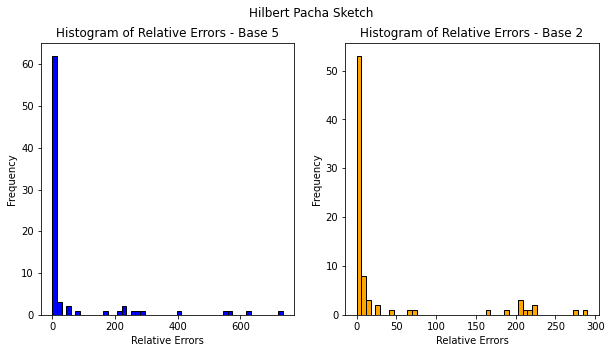

In [44]:
plt.figure(figsize=(10, 5))
plt.suptitle('Hilbert Pacha Sketch')

plt.subplot(1, 2, 1)
plt.hist(relative_errors_h_5, bins=50, edgecolor='black', color='blue')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors - Base 5')

plt.subplot(1, 2, 2)
plt.hist(relative_errors_h_2, bins=50, edgecolor='black', color='orange')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors - Base 2')

plt.show()

In [46]:
true_results_v2, estimates_v2, absolute_errors_v2, relative_errors_v2 = evaluate_queries(pacha_sketch=hilbert_pacha_sketch_5_v2, queries=queries_5)

level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


In [1]:
# Plot the histogram
plt.hist(relative_errors_v2, bins=50, edgecolor='black')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors')
plt.show()

NameError: name 'plt' is not defined

## Plots Presentation

In [32]:
true_results_s_5, estimates_s_5, absolute_errors_s_5, relative_errors_s_5, times_s_5 = evaluate_queries(pacha_sketch=spatial_pacha_sketch_5, queries=queries_5, flat_results=False)


level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


In [36]:
true_results_h_5, estimates_h_5, absolute_errors_h_5, relative_errors_h_5, times_h_5 = evaluate_queries(pacha_sketch=hilbert_pacha_sketch_5_v2, queries=queries_5, flat_results=False)


level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


In [37]:
true_results_cm, estimates_cm, absolute_errors_cm, relative_errors_cm, times_cm = evaluate_queries(pacha_sketch=cm_baseline, queries=queries_5, flat_results=False)


level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


In [39]:
times_h_5

[[0.0006353855133056641,
  0.0006430149078369141,
  0.0005514621734619141,
  0.0005676746368408203,
  0.0006058216094970703,
  0.0005438327789306641,
  0.0005376338958740234,
  0.0004782676696777344,
  0.0003654956817626953,
  0.000484466552734375,
  0.0009419918060302734,
  0.00039458274841308594,
  0.0003635883331298828,
  0.00034427642822265625,
  0.000385284423828125,
  0.0003879070281982422,
  0.00036334991455078125,
  0.0003352165222167969,
  0.0003368854522705078,
  0.0004394054412841797],
 [0.01005864143371582,
  0.007860898971557617,
  0.010951757431030273,
  0.007661104202270508,
  0.008176803588867188,
  0.007842779159545898,
  0.007303476333618164,
  0.008158445358276367,
  0.007548093795776367,
  0.008395671844482422,
  0.00731658935546875,
  0.009090423583984375,
  0.007738828659057617,
  0.006775379180908203,
  0.008074522018432617,
  0.008491992950439453,
  0.009389877319335938,
  0.007536172866821289,
  0.008028030395507812,
  0.011589527130126953],
 [0.321617603302001

In [38]:
times_cm

[[3.075599670410156e-05,
  2.7894973754882812e-05,
  3.457069396972656e-05,
  2.7179718017578125e-05,
  2.5510787963867188e-05,
  2.193450927734375e-05,
  2.3603439331054688e-05,
  2.0503997802734375e-05,
  1.9311904907226562e-05,
  1.6927719116210938e-05,
  1.8358230590820312e-05,
  1.3589859008789062e-05,
  1.5497207641601562e-05,
  2.002716064453125e-05,
  1.6689300537109375e-05,
  1.2636184692382812e-05,
  1.1682510375976562e-05,
  1.239776611328125e-05,
  1.1444091796875e-05,
  1.9073486328125e-05],
 [0.0004649162292480469,
  0.0006086826324462891,
  0.0004305839538574219,
  0.00043582916259765625,
  0.0004241466522216797,
  0.00045228004455566406,
  0.0004055500030517578,
  0.00043892860412597656,
  0.0003616809844970703,
  0.0004379749298095703,
  0.0003261566162109375,
  0.0003333091735839844,
  0.0003190040588378906,
  0.00034332275390625,
  0.0003361701965332031,
  0.00033593177795410156,
  0.00030612945556640625,
  0.0002951622009277344,
  0.0002930164337158203,
  0.00029039

In [47]:
relative_errors_cm_flat = np.array(relative_errors_cm).flatten()
relative_errors_h_5_flat = np.array(relative_errors_h_5).flatten()
relative_errors_s_5_flat = np.array(relative_errors_s_5).flatten()

In [70]:
len(relative_errors_h_5)

4

In [48]:
bins = np.histogram(np.hstack((relative_errors_cm_flat, relative_errors_h_5_flat, relative_errors_s_5_flat)), bins=50)[1]

In [52]:

# Flattened relative error arrays
all_values = np.hstack((relative_errors_cm_flat, relative_errors_h_5_flat, relative_errors_s_5_flat))

# Avoid issues with zero values by setting a small positive lower bound
min_val = np.min(all_values[all_values > 0])  # Minimum non-zero value
max_val = np.max(all_values)

# Define log-spaced bins
num_bins = 50
bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)


In [58]:
bins[0] = 0.0

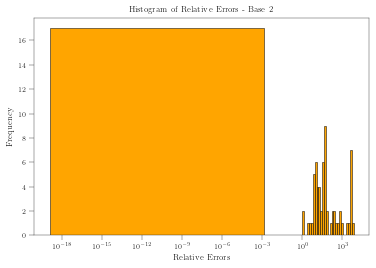

In [59]:
# plt.figure(figsize=(2.0, 1.2))
plt.hist(relative_errors_cm_flat, bins=bins, edgecolor='black', color='orange')
plt.xscale('log')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors - Base 2')

plt.show()

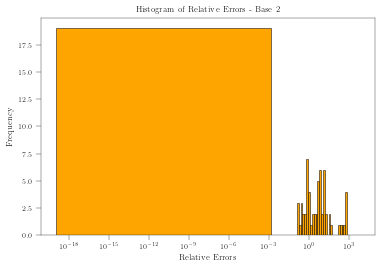

In [60]:
# plt.figure(figsize=(2.0, 1.2))
plt.hist(relative_errors_h_5_flat, bins=bins, edgecolor='black', color='orange')
plt.xscale('log')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors - Base 2')

plt.show()

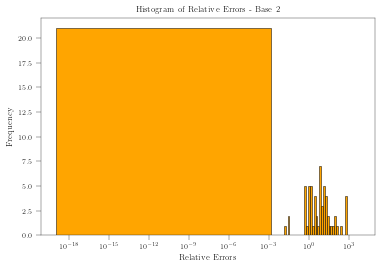

In [61]:
# plt.figure(figsize=(2.0, 1.2))
plt.hist(relative_errors_s_5_flat, bins=bins, edgecolor='black', color='orange')
plt.xscale('log')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors - Base 2')

plt.show()

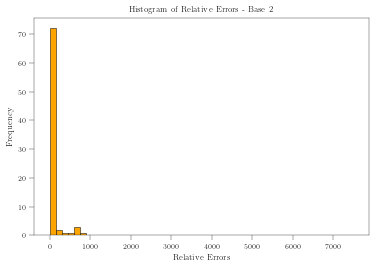

In [50]:
plt.hist(relative_errors_h_5_flat, bins=bins, edgecolor='black', color='orange')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors - Base 2')

plt.show()

/tmp/ipykernel_923/1150102398.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 1000)


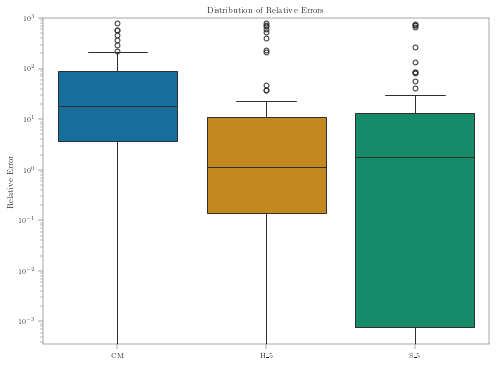

In [69]:

# Combine the data into a list for plotting
data = [
    relative_errors_cm_flat,
    relative_errors_h_5_flat,
    relative_errors_s_5_flat
]

# Define labels for each distribution
labels = ["CM", "H_5", "S_5"]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yscale("log")
plt.ylabel("Relative Error")
plt.title("Distribution of Relative Errors")
plt.ylim(0.0, 1000)

# Show the plot
plt.show()


/tmp/ipykernel_923/324075824.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 1000)


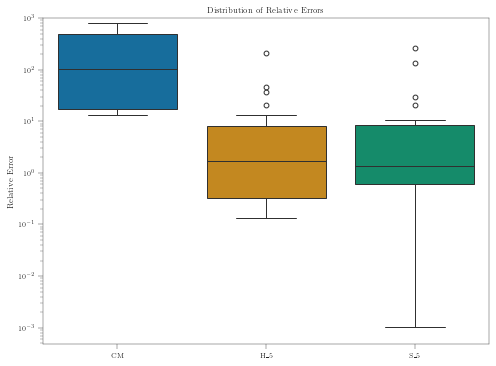

In [67]:
# Combine the data into a list for plotting
data = [
    relative_errors_cm[-1],
    relative_errors_h_5[-1],
    relative_errors_s_5[-1]
]

# Define labels for each distribution
labels = ["CM", "H_5", "S_5"]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yscale("log")
plt.ylabel("Relative Error")
plt.title("Distribution of Relative Errors")
plt.ylim(0.0, 1000)
# Show the plot
plt.show()

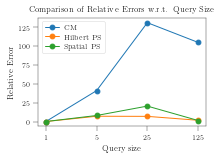

In [101]:
plt.figure(figsize=(3.0, 2.0))
# Convert lists to numpy arrays for easier computation
cm_array = np.array(relative_errors_cm)  # Shape (4, 20)
h_5_array = np.array(relative_errors_h_5)  # Shape (4, 20)
s_5_array = np.array(relative_errors_s_5)  # Shape (4, 20)

# Function to compute median, Q1 (25th percentile), and Q3 (75th percentile)
def compute_stats(array):
    median = np.median(array, axis=1)  # Median per group
    q1 = np.percentile(array, 25, axis=1)  # 1st quartile
    q3 = np.percentile(array, 75, axis=1)  # 3rd quartile
    return median, q1, q3

cm_median, cm_q1, cm_q3 = compute_stats(cm_array)
h_5_median, h_5_q1, h_5_q3 = compute_stats(h_5_array)
s_5_median, s_5_q1, s_5_q3 = compute_stats(s_5_array)

# X-axis positions
x = np.arange(1, 5)

# Plot median lines with vertical error bars (Q1 to Q3)
plt.plot(x, cm_median, marker="o", label="CM", color="tab:blue")
plt.plot(x, h_5_median, marker="o", label="Hilbert PS", color="tab:orange")
plt.plot(x, s_5_median, marker="o", label="Spatial PS", color="tab:green")

# Labels and title
plt.xlabel("Query size")
plt.ylabel("Relative Error")
plt.title("Comparison of Relative Errors w.r.t. Query Size")
plt.xticks(x, labels=[f"{5**i}" for i in range(0, 4)])  # Custom x-axis labels
plt.legend()

# plt.ylim(0.0, 200)


# Show the plot
# plt.savefig("figures/relative_error_query_size.png", bbox_inches = 'tight', pad_inches = 0.05, dpi=199)
plt.show()


In [106]:
cm_median / s_5_median

array([0.26567657, 0.1998378 , 1.34896982, 5.2062996 ])

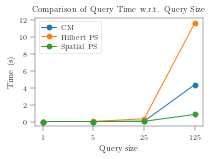

In [105]:
plt.figure(figsize=(3.0, 2.0))
cm_array = np.array(times_cm)  # Shape (4, 20)
h_5_array = np.array(times_h_5)  # Shape (4, 20)
s_5_array = np.array(times_s_5)  # Shape (4, 20)

# Function to compute median, Q1 (25th percentile), and Q3 (75th percentile)
def compute_stats(array):
    median = np.median(array, axis=1)  # Median per group
    q1 = np.percentile(array, 25, axis=1)  # 1st quartile
    q3 = np.percentile(array, 75, axis=1)  # 3rd quartile
    return median, q1, q3

cm_median, cm_q1, cm_q3 = compute_stats(cm_array)
h_5_median, h_5_q1, h_5_q3 = compute_stats(h_5_array)
s_5_median, s_5_q1, s_5_q3 = compute_stats(s_5_array)

# X-axis positions
x = np.arange(1, 5)

# Plot median lines with vertical error bars (Q1 to Q3)
plt.plot(x, cm_median, marker="o", label="CM", color="tab:blue")
plt.plot(x, h_5_median, marker="o", label="Hilbert PS", color="tab:orange")
plt.plot(x, s_5_median, marker="o", label="Spatial PS", color="tab:green")

# Labels and title
plt.xlabel("Query size")
plt.ylabel("Time (s)")
plt.title("Comparison of Query Time w.r.t. Query Size")
plt.xticks(x, labels=[f"{5**i}" for i in range(0, 4)])  # Custom x-axis labels
plt.legend()

# plt.ylim(0.0, 200)

# plt.savefig("figures/query_time_query_size.png", bbox_inches = 'tight', pad_inches = 0.05, dpi=199)

# Show the plot
plt.show()
